### Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import sys
sys.path.append("../../") # Add parent directory to sys.path to access preprocessing module
sys.path.append("../") # Add parent directory to sys.path to access preprocessing module

from preprocessing.data_augmentor import DataAugmentor
from preprocessing.feature_extractor import FeatureExtractor
from preprocessing.sampler import Sampler

## Data Preparation

In [2]:
data_dir = "../../data/Composer_Dataset"
composers = ["Bach", "Beethoven", "Chopin", "Mozart"]
scalar_features, multidimensional_features = FeatureExtractor.extract_features_for_directory(data_dir, composers)

Loading existing features from ../../data/Composer_Dataset/extracted_features.pkl


In [3]:
scalar_features.head()

,max_independent_voices,avg_independent_voices,var_independent_voices,avg_simultaneity,var_simultaneity,note_density,avg_note_duration,var_note_duration,initial_tempo,time_signature_numerator,...,perfect_vertical_intervals,vertical_minor_seconds,vertical_thirds,vertical_fifths,vertical_tritones,vertical_octaves,avg_chord_duration,length,file_name,composer
0,4.0,3.899642,0.300477,3.720000,1.020588,6.439026,0.621212,0.296121,143.000038,4.0,...,0.391195,0.000000,0.327044,0.200000,0.045283,0.122013,0.465000,29.999992,042100b_.mid,Bach
1,4.0,3.986667,0.114698,3.600000,1.200000,7.394595,0.526316,0.250579,189.176471,4.0,...,0.400447,0.005220,0.307979,0.168531,0.042506,0.123788,0.321429,25.000000,043100b_.mid,Bach
2,7.0,2.664012,1.617631,2.331998,1.816512,6.292553,0.371665,0.686803,181.905446,4.0,...,0.378734,0.006634,0.291590,0.120602,0.057594,0.158185,0.177695,923.701235,Bwv0564-Toccata-Adagio-and-Fugue.mid,Bach
3,4.0,3.970874,0.168160,3.662222,1.112213,8.775758,0.455801,0.212811,177.509434,4.0,...,0.375205,0.009852,0.312808,0.130542,0.030378,0.115764,0.321875,22.500000,027400b_.mid,Bach
4,4.0,3.917323,0.275394,3.455782,1.371385,5.195127,0.713614,0.442007,153.000153,4.0,...,0.478439,0.002738,0.309377,0.206023,0.016427,0.140999,0.470370,29.333304,026400b_.mid,Bach


In [4]:
print(f"Piano Roll Shape: {multidimensional_features[0]['piano_roll'].shape}")
print(f"Chroma Piano Roll Shape: {multidimensional_features[0]['chroma_piano_roll'].shape}")
print(f"Pitch Class Histogram Shape: {multidimensional_features[0]['pitch_class_histogram'].shape}")
print(f"Pitch Class Transition Matrix Shape: {multidimensional_features[0]['pitch_class_transition_matrix'].shape}")

Piano Roll Shape: (128, 299)
Chroma Piano Roll Shape: (12, 299)
Pitch Class Histogram Shape: (12,)
Pitch Class Transition Matrix Shape: (12, 12)


### Train Val Test Split

In [5]:
y = scalar_features['composer']
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

scalar_train, scalar_holdout, multidim_train, multidim_holdout, y_train, y_holdout = Sampler.split_data(scalar_features, multidimensional_features, y, test_size=0.2, random_state=1)

scalar_val, scalar_test, multidim_val, multidim_test, y_val, y_test = Sampler.split_data(scalar_holdout, multidim_holdout, y_holdout, test_size=0.5, random_state=1)

train_composer_files = scalar_train[['composer', 'file_name']]
scalar_features = scalar_features.drop('file_name', axis=1)
scalar_train.drop(['composer', 'file_name'], axis=1, inplace=True)
scalar_val.drop(['composer', 'file_name'], axis=1, inplace=True)
scalar_test.drop(['composer', 'file_name'], axis=1, inplace=True)

/var/folders/v3/6g8j12qj0yd6zlbh6nr578p80000gn/T/ipykernel_93273/2216297816.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scalar_val.drop(['composer', 'file_name'], axis=1, inplace=True)
/var/folders/v3/6g8j12qj0yd6zlbh6nr578p80000gn/T/ipykernel_93273/2216297816.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scalar_test.drop(['composer', 'file_name'], axis=1, inplace=True)


{'Bach': 815, 'Mozart': 215, 'Beethoven': 176, 'Chopin': 102}


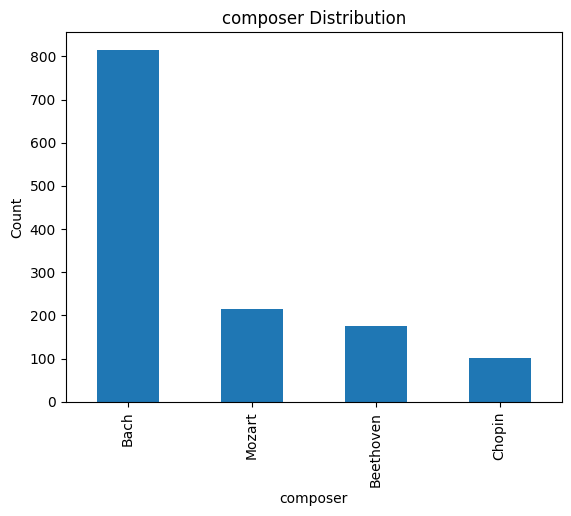

In [6]:
def plot_column_distribution(data: pd.DataFrame, column: str) -> None:
    print(dict(data[column].value_counts()))
    data[column].value_counts().plot(kind='bar')
    plt.title(f'{column} Distribution')
    plt.xlabel(f'{column}')
    plt.ylabel(f'Count')
    plt.show()
    
train_composers = pd.DataFrame(label_encoder.inverse_transform(y_train), columns=['composer'])
plot_column_distribution(train_composers, 'composer')

{'Mozart': 815, 'Bach': 815, 'Beethoven': 815, 'Chopin': 815}


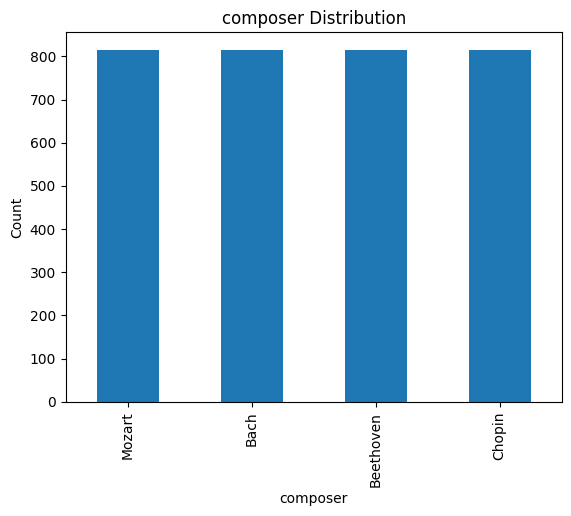

In [7]:
scalar_train, multidim_train, y_train = Sampler.oversample_balance(scalar_train, multidim_train, y_train)
train_composers = pd.DataFrame(label_encoder.inverse_transform(y_train), columns=['composer'])
plot_column_distribution(train_composers, 'composer')

In [8]:
num_augmented_songs = 100
mozart_aug_scalars, mozart_aug_multidim = DataAugmentor.generate_augmented_songs(data_dir, train_composer_files[train_composer_files['composer'] == 'Mozart'], num_augmented_songs)
bach_aug_scalars, bach_aug_multidim = DataAugmentor.generate_augmented_songs(data_dir, train_composer_files[train_composer_files['composer'] == 'Bach'], num_augmented_songs)
beethoven_aug_scalars, beethoven_aug_multidim = DataAugmentor.generate_augmented_songs(data_dir, train_composer_files[train_composer_files['composer'] == 'Beethoven'], num_augmented_songs)
chopin_aug_scalars, chopin_aug_multidim = DataAugmentor.generate_augmented_songs(data_dir, train_composer_files[train_composer_files['composer'] == 'Chopin'], num_augmented_songs)

scalar_train = pd.concat([scalar_train, mozart_aug_scalars, bach_aug_scalars, beethoven_aug_scalars, chopin_aug_scalars], axis=0)
multidim_train = multidim_train + mozart_aug_multidim + bach_aug_multidim + beethoven_aug_multidim + chopin_aug_multidim

Generating Augmented Songs:   0%|          | 0/100 [00:00<?, ?song/s]/Users/kdevoe/Documents/CS/Masters/AAI511/ms-aai-511-final-project/511_final_env/lib/python3.10/site-packages/numpy/lib/histograms.py:1124: RuntimeWarning: invalid value encountered in divide
  hist /= s
Generating Augmented Songs:  24%|██▍       | 24/100 [01:23<05:02,  3.98s/song]/Users/kdevoe/Documents/CS/Masters/AAI511/ms-aai-511-final-project/511_final_env/lib/python3.10/site-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
Generating Augmented Songs: 100%|██████████| 100/100 [01:27<00:00,  1.15song/s]


In [9]:
mozart_aug_y = np.full(num_augmented_songs, label_encoder.transform(['Mozart']))
bach_aug_y = np.full(num_augmented_songs, label_encoder.transform(['Bach']))
beethoven_aug_y = np.full(num_augmented_songs, label_encoder.transform(['Beethoven']))
chopin_aug_y = np.full(num_augmented_songs, label_encoder.transform(['Chopin']))
y_train = np.hstack((y_train, mozart_aug_y, bach_aug_y, beethoven_aug_y, chopin_aug_y))

{'Mozart': 915, 'Bach': 915, 'Beethoven': 915, 'Chopin': 915}


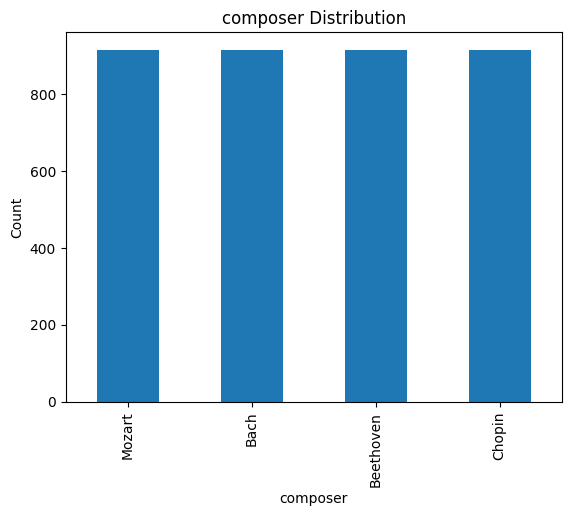

In [10]:
train_composers = pd.DataFrame(label_encoder.inverse_transform(y_train), columns=['composer'])
plot_column_distribution(train_composers, 'composer')

### Chunk Into Sequences

In [11]:
def chunk_sequences(X_in, y_in, feature, sequence_length=100):
    X_out = []
    y_out = []

    # make sequences split along the time axis
    for i in range(len(X_in)):
        for j in range(0, len(X_in[i][feature][1]) - sequence_length, sequence_length):
            X_out.append(X_in[i][feature][:, j:j + sequence_length])
            y_out.append(y_in[i])

    return X_out, y_out

### Make Dataloader

In [12]:
class PianoRollDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        X = torch.tensor(self.X[idx], dtype=torch.float32) 
        y = torch.tensor(self.y[idx], dtype=torch.long)
        return X, y

## Convolutional Neural Network (CNN)

A CNN was trained to take the multi-dimensional song data and predict the composer of the work. To fully utilize all the available data after the CNN was trained the outputs were fed into a separate classifier along with scalar features to predict the composer.

### Dataloaders

Dataloaders from PyTorch were used to load data in batches for training and evaluating the CNN model. The get_dataloaders function will generate dataloaders for the training, validation, and test sets.

In [13]:
def get_dataloaders(use_chroma, seq_length=100, batch_size=8):
    
    # Set random seed for PyTorch
    torch.manual_seed(42) 
    
    feature_set = 'chroma_piano_roll' if use_chroma else 'piano_roll'

    X_train_seq, y_train_seq = chunk_sequences(multidim_train, y_train, feature_set, seq_length)
    X_val_seq, y_val_seq = chunk_sequences(multidim_val, y_val, feature_set, seq_length)
    X_test_seq, y_test_seq = chunk_sequences(multidim_test, y_test, feature_set, seq_length)

    train_dataset = PianoRollDataset(X_train_seq, y_train_seq)
    val_dataset = PianoRollDataset(X_val_seq, y_val_seq)
    test_dataset = PianoRollDataset(X_test_seq, y_test_seq)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

### Define CNN Model

The overall architecture of the CNN model was kept simple, with 2 convolutional / pooling layers followed by two fully connected layers. The output of the CNN model is four values, one for each composer, which are used for multi-class classification between the four composers.

In [14]:
class PianoRollCNN(nn.Module):
    def __init__(self, h_params):
        super(PianoRollCNN, self).__init__()

        input_channels = 12 if h_params['use_chroma'] else 128

        self.conv1 = nn.Conv1d(input_channels, h_params['conv1_out_channels'], 
                               kernel_size=h_params['kernel_size'], stride=h_params['stride'], 
                               padding=h_params['kernel_size'] // 2)
        self.conv2 = nn.Conv1d(h_params['conv1_out_channels'], h_params['conv2_out_channels'], 
                               kernel_size=h_params['kernel_size'], stride=h_params['stride'],
                               padding=h_params['kernel_size'] // 2)
        self.pool = nn.MaxPool1d(kernel_size=h_params['pool_kernel_size'], stride=h_params['pool_stride'], padding=0)

        def conv_output_size(input_size, kernel_size, stride, padding):
            return (input_size - kernel_size + 2 * padding) // stride + 1
    
        padding = h_params['kernel_size'] // 2  # Assuming same padding

        # First conv layer output size
        conv1_output_width = conv_output_size(int(h_params['seq_length']), h_params['kernel_size'], h_params['stride'], padding)
        # First pooling layer output size
        pooled_width = conv_output_size(conv1_output_width, h_params['pool_kernel_size'], h_params['pool_stride'], 0)
        # Second conv layer output size
        conv2_output_width = conv_output_size(pooled_width, h_params['kernel_size'], h_params['stride'], padding)
        # Second pooling layer output size
        pooled_width = conv_output_size(conv2_output_width, h_params['pool_kernel_size'], h_params['pool_stride'], 0)

        self.fc1 = nn.Linear(h_params['conv2_out_channels'] * pooled_width, h_params['fc1_out'])
        self.dropout = nn.Dropout(h_params['dropout'])
        self.fc2 = nn.Linear(h_params['fc1_out'], 4)  # Output of 4 classes (composers)

    def forward(self, x):
        x = x.squeeze(2) 
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1) 
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

### Define Training Loop

In [15]:
def train_cnn(model, train_loader, val_loader, num_epochs, criterion, optimizer, silent=False):

    for epoch in range(num_epochs):

        # Training
        model.train()
        running_loss = 0.0
        report_interval = 1000
        for i, data in enumerate(train_loader):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if i % report_interval == (report_interval - 1) and not silent:
                print(f'[Epoch {epoch + 1}, Batch {i + 1}] loss: {running_loss / report_interval:.3f}')
                running_loss = 0.0  # Reset running loss

        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for data in val_loader:
                inputs, labels = data
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        if not silent:
            print(f'Validation loss: {val_loss / len(val_loader):.3f}, Accuracy: {100 * correct / total:.2f}%')

### Evaluate Performance

In [16]:
def evaluate_performance(model, data_loader, silent=False):
    model.eval()

    all_labels = []
    all_predictions = []

    # Disable gradient computation for evaluation
    with torch.no_grad():
        for data in data_loader:
            inputs, labels = data
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            # Store true and predicted labels
            all_labels.extend(labels.numpy())
            all_predictions.extend(predicted.numpy())

    # Compute the classification report
    report = classification_report(all_labels, all_predictions, target_names=label_encoder.classes_)

    if not silent:
        print(report)

    return report, all_labels, all_predictions

### Define Training Run

In [17]:
def training_run(h_params, silent=False):

    seq_length = int(h_params['seq_length'])
    batch_size = int(h_params['batch_size'])

    train_loader, val_loader, test_loader = get_dataloaders(h_params['use_chroma'], seq_length, batch_size)

    model = PianoRollCNN(h_params)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=h_params['lr'])
    train_cnn(model, train_loader, val_loader, h_params['num_epochs'], criterion, optimizer, silent)

    return model, val_loader

### Hyperparameter Search via Optuna Library

In [18]:
def objective(trial):
    # Define the hyperparameter search space
    h_params = {
        'use_chroma': False,
        'seq_length': trial.suggest_int('seq_length', 20, 100),
        'batch_size': trial.suggest_int('batch_size', 2, 64),
        'lr': trial.suggest_float('lr', 1e-5, 1e-2, log=True),
        'num_epochs': 3,
        'conv1_out_channels': trial.suggest_int('conv1_out_channels', 16, 64),
        'conv2_out_channels': trial.suggest_int('conv2_out_channels', 32, 128),
        'kernel_size': trial.suggest_int('kernel_size', 3, 9),
        'stride': 1,
        'pool_kernel_size': 2,
        'pool_stride': 2,
        'dropout': trial.suggest_float('dropout', 0.0, 0.5),
        'fc1_out': trial.suggest_int('fc1_out', 64, 256)
    }

    model, val_loader = training_run(h_params, silent=True)
    report, _, _ = evaluate_performance(model, val_loader, silent=True)

    return float(report.split('\n')[7].split()[1])

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print("Best Parameters: ", study.best_params)
print("Best Accuracy: ", study.best_value)

[I 2024-08-06 22:41:40,559] A new study created in memory with name: no-name-643e0720-4c23-4886-afa4-bc19e5a7b011
[I 2024-08-06 23:04:45,694] Trial 0 finished with value: 0.59 and parameters: {'seq_length': 31, 'batch_size': 23, 'lr': 4.196938940115864e-05, 'conv1_out_channels': 36, 'conv2_out_channels': 44, 'kernel_size': 7, 'dropout': 0.37513971177994393, 'fc1_out': 115}. Best is trial 0 with value: 0.59.
[I 2024-08-06 23:20:25,190] Trial 1 finished with value: 0.57 and parameters: {'seq_length': 52, 'batch_size': 55, 'lr': 0.0014886228293304808, 'conv1_out_channels': 43, 'conv2_out_channels': 92, 'kernel_size': 6, 'dropout': 0.1453869731295206, 'fc1_out': 86}. Best is trial 0 with value: 0.59.
[I 2024-08-06 23:30:14,292] Trial 2 finished with value: 0.63 and parameters: {'seq_length': 62, 'batch_size': 22, 'lr': 0.00011768048294869942, 'conv1_out_channels': 18, 'conv2_out_channels': 89, 'kernel_size': 3, 'dropout': 0.40376873830416604, 'fc1_out': 73}. Best is trial 2 with value: 0.6

Best Parameters:  {'seq_length': 83, 'batch_size': 64, 'lr': 0.000318541271307236, 'conv1_out_channels': 54, 'conv2_out_channels': 114, 'kernel_size': 8, 'dropout': 0.19512096269338727, 'fc1_out': 148}
Best Accuracy:  0.69


### Single Training Run

A single training run was performed with the best parameters found from the hyperparameter search.

In [30]:
test_params = {}

# Set all the hyperparameters to the best values found during optimization
for key, value in study.best_params.items():
    test_params[key] = value

test_params['use_chroma'] = False
test_params['num_epochs'] = 5
test_params['stride'] = 1
test_params['pool_kernel_size'] = 2
test_params['pool_stride'] = 2

model, test_dataloader = training_run(test_params)

report, _, _ = evaluate_performance(model, test_dataloader)

[Epoch 1, Batch 1000] loss: 0.962
[Epoch 1, Batch 2000] loss: 0.665
Validation loss: 0.935, Accuracy: 65.65%
[Epoch 2, Batch 1000] loss: 0.461
[Epoch 2, Batch 2000] loss: 0.387
Validation loss: 0.970, Accuracy: 68.08%
[Epoch 3, Batch 1000] loss: 0.271
[Epoch 3, Batch 2000] loss: 0.252
Validation loss: 1.221, Accuracy: 68.64%
[Epoch 4, Batch 1000] loss: 0.179
[Epoch 4, Batch 2000] loss: 0.189
Validation loss: 1.443, Accuracy: 67.30%
[Epoch 5, Batch 1000] loss: 0.128
[Epoch 5, Batch 2000] loss: 0.141
Validation loss: 1.564, Accuracy: 68.84%
              precision    recall  f1-score   support

        Bach       0.84      0.81      0.83      1740
   Beethoven       0.50      0.60      0.55       891
      Chopin       0.64      0.63      0.64       289
      Mozart       0.66      0.60      0.63      1429

    accuracy                           0.69      4349
   macro avg       0.66      0.66      0.66      4349
weighted avg       0.70      0.69      0.69      4349



### Combine CNN Predictions with Scalar Features for Classification

Given a single input track make a prediction for each composer using the CNN classifier.

In [20]:
def get_prediction(X_in, feature, sequence_length=100):
    X_sequences = []

    # make sequences split along the time axis
    for j in range(0, len(X_in[feature][1]) - sequence_length, sequence_length):
        X_sequences.append(X_in[feature][:, j:j + sequence_length])
    
    predictions = []

    for i in range(len(X_sequences)):
        inputs = torch.tensor(X_sequences[i], dtype=torch.float32)
        outputs = model(inputs.unsqueeze(0))
        predictions.append(outputs.tolist())

    # Average the prediction values across the sequences
    predictions = torch.tensor(predictions).mean(dim=0)

    return predictions.tolist()[0]

### Add CNN Outputs to Scalar Features

In [21]:
def add_cnn_predictions(multidimensional_features, scalar_features, feature, sequence_length=100):

    # Use the index list of scalar_features to add cnn predictions to correct rows
    index_list = scalar_features.index.tolist()

    for i, md_row in enumerate(multidimensional_features):
        predictions = get_prediction(md_row, feature, sequence_length)
        for idx, prediction in enumerate(predictions):
            column = "composer_" + str(idx)
            scalar_features.loc[index_list[i], column] = prediction

In [22]:
cnn_scalar_train = scalar_train.copy()
add_cnn_predictions(multidim_train, cnn_scalar_train, 'piano_roll', study.best_params['seq_length'])


cnn_scalar_test = scalar_test.copy()
add_cnn_predictions(multidim_test, cnn_scalar_test, 'piano_roll', study.best_params['seq_length'])

### Run Classifier Using CNN Predictions and Scalar Features

In [23]:
classifier = HistGradientBoostingClassifier(random_state=1)
classifier.fit(cnn_scalar_train, y_train)

HistGradientBoostingClassifier(random_state=1)

In [24]:
y_pred = classifier.predict(cnn_scalar_test)
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

Classification Report:
              precision    recall  f1-score   support

        Bach       0.90      0.98      0.94       101
   Beethoven       0.64      0.64      0.64        22
      Chopin       1.00      0.64      0.78        22
      Mozart       0.72      0.68      0.70        19

    accuracy                           0.85       164
   macro avg       0.81      0.73      0.76       164
weighted avg       0.86      0.85      0.85       164



### Fine Tune Classifier

In [25]:
# Define the hyperparameter grid
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_iter': [100, 200, 300],
    'max_leaf_nodes': [31, 50, 100],
    'max_depth': [3, 5, 7],
}

In [26]:
from sklearn.model_selection import GridSearchCV

# Initialize the classifier
hgb_clf = HistGradientBoostingClassifier(random_state=42)

# Set up the GridSearchCV
grid_search = GridSearchCV(estimator=hgb_clf, param_grid=param_grid, 
                           scoring='accuracy', cv=5, n_jobs=-1, verbose=0)

# Fit the grid search to the data
grid_search.fit(cnn_scalar_train, y_train)

GridSearchCV(cv=5, estimator=HistGradientBoostingClassifier(random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7], 'max_iter': [100, 200, 300],
                         'max_leaf_nodes': [31, 50, 100]},
             scoring='accuracy')

In [27]:
# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Hyperparameters:", best_params)
print("Best Cross-Validated Score:", best_score)

# Evaluate on the test set
best_model = grid_search.best_estimator_
test_score = best_model.score(cnn_scalar_test, y_test)
print("Test Set Accuracy:", test_score)

Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 3, 'max_iter': 300, 'max_leaf_nodes': 31}
Best Cross-Validated Score: 0.9387978142076504
Test Set Accuracy: 0.8841463414634146
